# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

0.0 255.0


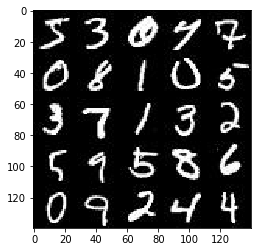

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

0.0 255.0


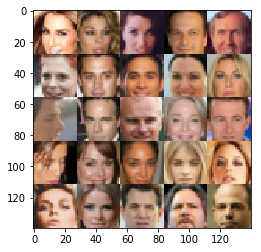

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="images")
    z_data = tf.placeholder(tf.float32, [None, z_dim], name="z_data")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [337]:
alpha = 0.2
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)

        x3 = tf.layers.conv2d(x2, 512, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        
        flat = tf.reshape(x3, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        result = tf.sigmoid(logits)
        
        return result, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [346]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        out = tf.tanh(logits)# * 0.5
        # a sigmoid - 0.5 seems to do the same thing
        # multiplying the batchesby 2 (another solution to this) has no appreciable difference I've been able to see.

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [349]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [350]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    
    #trying this solution from forums...
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_update_ops):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [351]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [352]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    
    losses = []
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={lr: learning_rate, input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={lr: learning_rate, input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                    if steps % 100 == 0:
                        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
        #final result
        print("Result for lr={} and beta1={}".format(learning_rate, beta1))
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
        plt.plot(losses.T[1], label='Generator', alpha=0.5)
        plt.title("Training Losses")
        plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.0148
Epoch 1/2... Discriminator Loss: 2.4770... Generator Loss: 0.1795
Epoch 1/2... Discriminator Loss: 1.7674... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 0.8291
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.0777
-0.55287 0.0420931


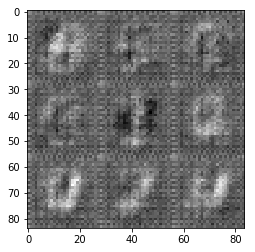

Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 0.9931
-0.921025 0.139361


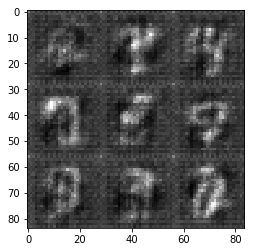

Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 2.4553
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 2.9459
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 2.2210
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.4618
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 0.9949
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.2396
-0.996473 0.82502


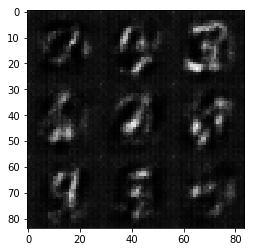

Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.2752
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 0.6567... Generator Loss: 1.9764
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 2.4115
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 2.8875
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 2.9888
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.9347
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 0.8654
-0.999982 0.985856


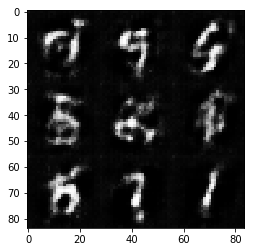

Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 2.9146
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 1.6516
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 2.7028
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 2.8804
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 0.7088... Generator Loss: 1.4568
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 3.1160
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.9150
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.5983
-1.0 0.999991


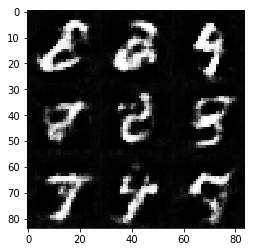

Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 1.8739
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.3315
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.6425
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 2.4138
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.4828
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.2777
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.0566
-1.0 0.999999


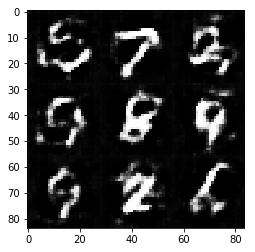

Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.4362
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.5279
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 1.2001
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 0.4970
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.1260
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 2.0771
Epoch 2/2... Discriminator Loss: 2.8583... Generator Loss: 4.2702
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.6624
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.2165
-1.0 1.0


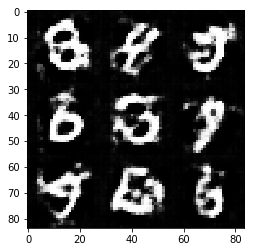

Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.2069
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.7158
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.7979
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.4498
Epoch 2/2... Discriminator Loss: 1.4969... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.4023
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.2196
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.3485
-1.0 1.0


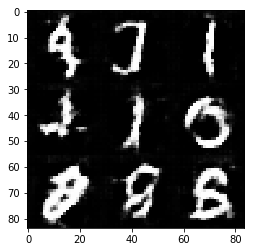

Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 2.0021
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 3.0131
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 2.7940
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.4524
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 1.7212
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 1.5818
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.9396
-1.0 1.0


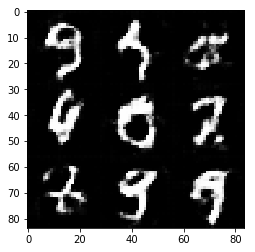

Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.6026
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.3972
Result for lr=0.0001 and beta1=0.1
-1.0 1.0


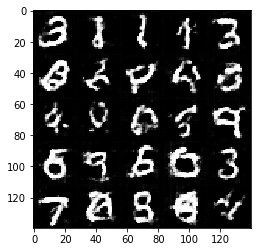

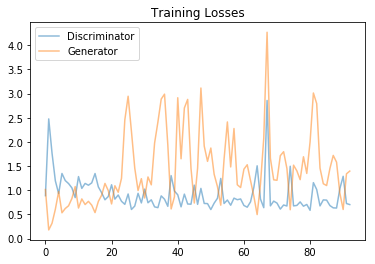

In [353]:
batch_size = 128
z_dim = 100
learning_rate = .0001
beta1 = .1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

with tf.Graph().as_default():
    mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
        mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.4864
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.8289
Epoch 1/1... Discriminator Loss: 3.1003... Generator Loss: 0.1330
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 2.8374... Generator Loss: 13.5120
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 3.9893
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 2.9758
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.9712
-0.561103 0.295542


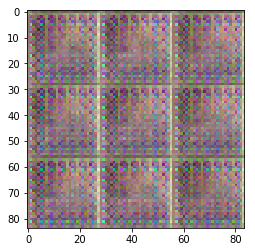

Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.8934
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 3.4022
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 3.5406
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 4.9364
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.4461
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 3.5097
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 3.7862
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 2.7646
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.8875
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 3.0712
-0.889417 0.326734


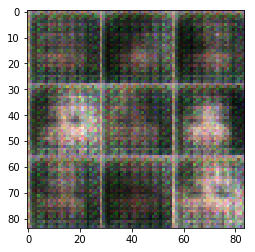

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 3.4426
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 3.2174
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 4.1834
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 4.0198
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 2.6957
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 3.3800
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 4.4431
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 3.0646
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.5503
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 2.7360
-0.971867 0.625023


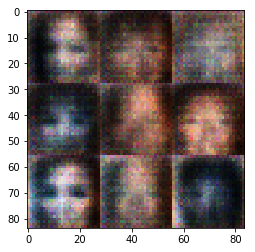

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 3.2050
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 2.9505
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 3.0932
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.6236
-0.98562 0.932611


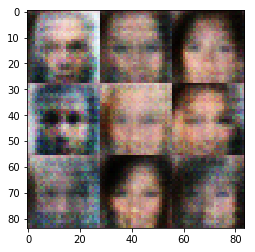

Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.6971
-0.993188 0.981292


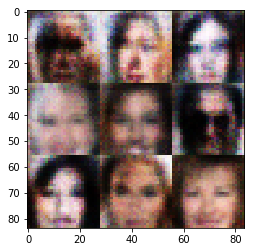

Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.6963
-0.998624 0.998842


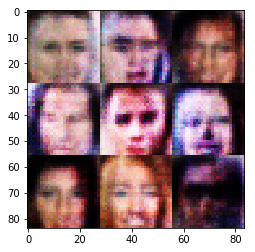

Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 4.1616
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 3.3143
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 3.9857
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 3.3490
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.3072
-0.999812 0.998111


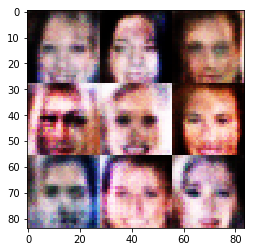

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 5.6232
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 3.9164
-0.999994 0.995371


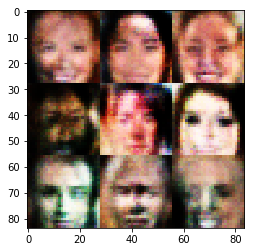

Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 3.4596
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.4307
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.1149
-0.999373 0.998795


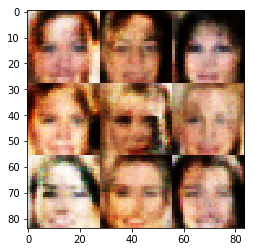

Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 6.5441
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 6.0542
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 2.2753
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 5.6779
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.0400
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 2.6089
-0.99999 0.999944


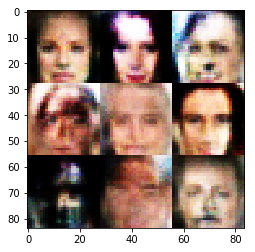

Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.8132
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 5.6134
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.9465
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.7732
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.2733
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 4.7833
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 4.6629
-0.999569 0.999747


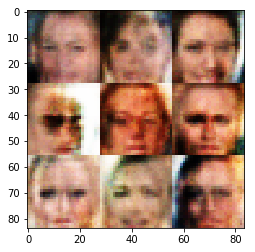

Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 2.8699... Generator Loss: 4.5301
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 4.6606
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 3.7106
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 4.8218
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 5.0175
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.5703
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 2.6203
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.9550
-0.999998 0.999246


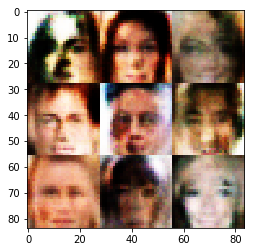

Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.3187
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 4.9822
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 4.8707
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.6357
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 5.1236
-0.999631 0.995907


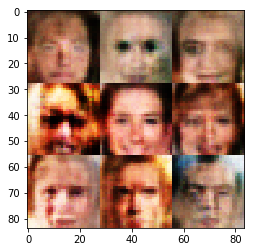

Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 6.0084
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 3.5011
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 1.7288
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.5386
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.7660
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.5395
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 5.2647
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 5.5700
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 2.1122
-0.999899 0.991387


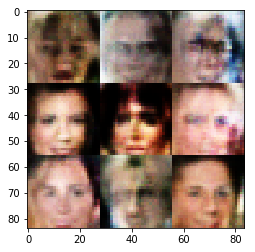

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.5762
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 2.8879
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 5.2121
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.7794
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.1899
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.2102
-0.999993 0.992052


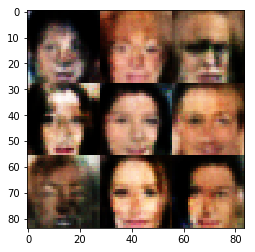

Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 5.7478
Epoch 1/1... Discriminator Loss: 2.1576... Generator Loss: 4.3023
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 3.7422
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 3.0091
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 4.8600
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 4.3492
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 4.7619
Result for lr=0.0001 and beta1=0.1
-0.999948 0.999773


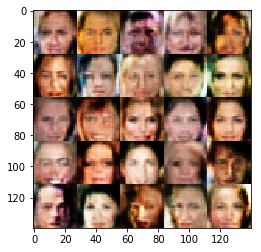

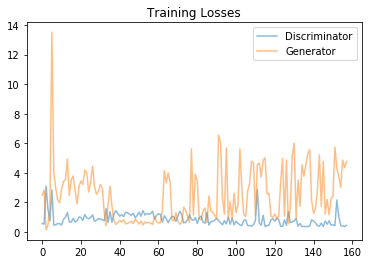

In [354]:
batch_size = 128
z_dim = 100
learning_rate = .0001
beta1 = .1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.